<a href="https://colab.research.google.com/github/Howuhh/dul_2021/blob/hw8/Homework/hw8/Homework8_DRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 339 (delta 100), reused 78 (delta 60), pack-reused 163
Receiving objects: 100% (339/339), 55.19 MiB | 26.25 MiB/s, done.
Resolving deltas: 100% (157/157), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./

In [2]:
from dul_2021.utils.hw8_utils import *

# Question 1. KMM

## Notations from practice

*   $p_{nu}(x)$ - pdf of numerator
*   $p_{de}(x)$ - pdf of denominator
*   $r(x)=\frac{p_{nu}(x)}{p_{de}(x)}$ - density ratio
*   $p_{nu}^*, p_{du}^*, r^*$ - estimatinos of respective functions
*   $\{x^{nu}_i\}_{i=1}^{n_{nu}}$ - sample from numerator distribution
*   $\{x^{de}_i\}_{i=1}^{n_{de}}$ - sample from denominator distribution



## KMM objective

Here we will implement Kernel Mean Matching (KMM) method for density ratio estimation. The basic idea of KMM is to 'match' expections of kernel function:

$$argmin_{r^*} ||E_{p_{de}}r^*(x)K(\cdot, x) - E_{p_{nu}}K(\cdot, x)||$$

Where $K(x, x') = exp(-\frac{|x-y|^2}{2\sigma^2})$. Emperical variant of this objective can be rewritten as follows:

$$argmin_{r^*} \frac{1}{n_{de}^2} (r^*_{de})^t K_{de, de} r^*_{de} - \frac{2}{n_{nu}n_{de} }(r^*_{de})^t K_{de, nu}1_{n_{nu}}$$

Where


*   $r^*_{de}$ - vector with $(r^*_{de})_i=r^*(x^{de}_i)$
*   $K_{de, de}$ - matrix with $(K_{de, de})_{i, j} = K(x^{de}_i, x^{de}_j)$
*   $K_{de, nu}$ - matrix with $(K_{de, nu})_{i, j} = K(x^{de}_i, x^{nu}_j)$
*   $1_{n_{nu}}$ - vector with $n_{nu}$ ones


## You will provide these deliverables
Density ratio on $[-2, 2]$.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import torch.utils.data as data

from torch.distributions import MultivariateNormal
from tqdm.auto import tqdm, trange

import numpy as np


class KernelMeanMatching(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, sigma=0.1):
        super().__init__()
        self.r = nn.Sequential(nn.Linear(1, hidden_dim), 
                               nn.ReLU(),
                               nn.Linear(hidden_dim, hidden_dim), 
                               nn.ReLU(),
                               nn.Linear(hidden_dim, 1),
                               nn.Softplus())
        self.sigma = sigma

    def __kernel(self, x, y):
        return (-(x - y.T)**2 / (2 * self.sigma)).exp()

    def fit(self, data_nu, data_de, batch_size=512, lr=1e-3, num_epochs=1000):
        loader_nu = data.DataLoader(data_nu, batch_size=batch_size, shuffle=True)
        loader_de = data.DataLoader(data_de, batch_size=batch_size, shuffle=True)
        optim = opt.Adam(self.r.parameters(), lr=lr)

        for epoch in tqdm(range(num_epochs)):
            for (batch_nu, batch_de) in zip(loader_nu, loader_de):
                batch_nu = batch_nu.view(-1, 1).float().to(device)
                batch_de = batch_de.view(-1, 1).float().to(device)

                n_nu, n_de = batch_nu.shape[0], batch_de.shape[0]

                r_de = self.r(batch_de)
                K_de_de = self.__kernel(batch_de, batch_de)
                K_de_nu = self.__kernel(batch_de, batch_nu)                
                I = torch.ones_like(batch_nu).to(device)

                loss = r_de.T @ (1 / n_de**2 * K_de_de @ r_de - 2 / (n_de * n_nu) * K_de_nu @ I)

                optim.zero_grad()
                loss.backward()
                optim.step()

    def forward(self, x):
        return self.r(x)

In [ ]:
def q1(data_nu, data_de):
    """
    data_nu - An [n_nu] dataset with samples from numerator's distribution
    data_de - An [n_de] dataset with samples from denominators's distribution
    
    Returns
      - a np.array with density ratios of np.linspace(-2., 2, num=100)
    """
    model = KernelMeanMatching(input_dim=1, hidden_dim=128, sigma=0.1).to(device)
    model.fit(data_nu, data_de, batch_size=512, lr=1e-3, num_epochs=1000)

    x = torch.linspace(-2., 2., 100).view(-1, 1).to(device)

    return model(x).detach().cpu().numpy()

  0%|          | 0/1000 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

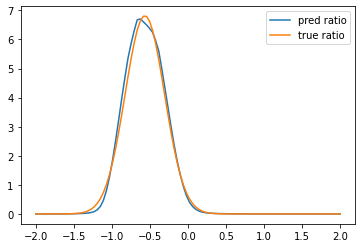

In [ ]:
q1_results(q1)

# Question 2. AVB

Here we will implement [Adversairal Variational Bayes](https://dl.acm.org/doi/pdf/10.5555/3305890.3305928).

You may experiment with different hyperparameters and architecture designs, but the following designs for the AVB architecture may be useful.

```
Classifier (T)
    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(),
    # reshape + add latent
    Linear(4 * 4 * 128 + ld, hd), 
    ReLU(),
    Linear(hd, hd), 
    ReLU(),
    Linear(hd, 1)


Encoder (E)

    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(), 
    # add noise + reshape
    Linear(4 * 4 * 128 + nd, ld)

Decoder (D)
    ConvTranspose2d(128, 128, 3, 2, 1), 
    ReLU(), 
    ConvTranspose2d(128, 64, 4, 2, 1), 
    ReLU(), 
    ConvTranspose2d(64, 32, 4, 2, 1), 
    ReLU(), 
    Conv2d(32, 1, 3, 1, 1)
    # reshape
    Linear(ld, 4 * 4 * 128), 
    ReLU()
```

**Reminder.** Objective for AVB

$$max_{\theta, \phi} E \log p_\theta(x|z_\phi(x)) - T(x, z_\phi(x))$$
$$max_{T} E_x \bigg(E_{q_\phi(z|x)} \log\big(\sigma (T(x, z))\big) + E_{p(z)} \log\big(1 - \sigma (T(x, z))\big)\bigg) $$

$\phi$ - parameters of encoder, $\theta$ - parameters of decoder


**You will provide the following deliverables**


1.   Over the course of training, record the elbo and loss of the classifier T ber batch.
2. Report the final test set performances of your final models
3. 100 samples from your trained AVB

In [5]:
class Classifier(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(4 * 4 * 128 + latent_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
  
    def forward(self, x, z):
        return self.classifier(
            torch.cat((self.encoder(x).flatten(1), z), dim=1)
        )


class Encoder(nn.Module):
    def __init__(self, latent_dim, noise_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU()
        )
        self.linear = nn.Linear(4 * 4 * 128 + noise_dim, latent_dim)
        self.noise_dist = MultivariateNormal(
            torch.zeros(noise_dim, device=device, dtype=torch.float),
            torch.eye(noise_dim, device=device, dtype=torch.float)
        )

    def forward(self, x, noise):
        return self.linear(
            torch.cat((self.encoder(x).flatten(1), noise), dim=1)
        )


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 128),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(128, 64, 4, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(64, 32, 4, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(32, 1, 3, 1, 1)
        )
  
    def forward(self, z):
        return self.decoder(
            self.linear(z).view(-1, 128, 4, 4)
        )

In [24]:
class AVB(nn.Module):
    def __init__(self, latent_dim=64, noise_dim=16, hidden_dim=256):
        super().__init__()

        self.classifier = Classifier(latent_dim, hidden_dim)
        self.encoder = Encoder(latent_dim, noise_dim)
        self.decoder = Decoder(latent_dim)

        self.latent_dist = MultivariateNormal(
            torch.zeros(latent_dim, device=device, dtype=torch.float),
            torch.eye(latent_dim, device=device, dtype=torch.float)
        )

    def __gen_loss(self, batch):
        noise = self.encoder.noise_dist.sample((batch.shape[0],))

        z = self.encoder(batch, noise)
        batch_recon = self.decoder(z)

        T = self.classifier(batch, z.detach()).mean()
        elbo_loss = T + F.binary_cross_entropy_with_logits(batch_recon, batch, reduction="none").sum((-1, -2, -3)).mean()

        return elbo_loss

    def __clf_loss(self, batch):
        batch_size = batch.shape[0]

        z_real = self.encoder(
            batch,
            self.encoder.noise_dist.sample((batch_size,))
        )
        z_fake = self.latent_dist.sample((batch_size,))

        T_real = self.classifier(batch, z_real.detach()).squeeze()
        T_fake = self.classifier(batch, z_fake.detach()).squeeze()

        loss_real = F.binary_cross_entropy_with_logits(T_real, torch.ones_like(T_real))
        loss_fake = F.binary_cross_entropy_with_logits(T_fake, torch.zeros_like(T_fake))

        clf_loss = loss_real + loss_fake

        return clf_loss

    @torch.no_grad()
    def test(self, test_dataloader):
        self.eval()
        elbo_losses, clf_losses = [], []

        for batch in test_dataloader:
            batch = batch.to(device)

            elbo_loss = self.__gen_loss(batch)
            clf_loss = self.__clf_loss(batch)

            elbo_losses.append(elbo_loss.item())
            clf_losses.append(clf_loss.item())

        self.train()

        return np.mean(elbo_losses), np.mean(clf_losses)

    def fit(self, train_dataloader, test_dataloader, epochs=20, lr=1e-3):
        test_losses, train_losses = [self.test(test_dataloader)], []

        gen_optim = opt.Adam(
            list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=lr
        )
        clf_optim = opt.Adam(self.classifier.parameters(), lr=lr)

        for epoch in trange(epochs, desc="Training"):
            for batch in tqdm(train_dataloader, desc="Epoch", leave=False):
                batch = batch.to(device)

                elbo_loss = self.__gen_loss(batch)

                gen_optim.zero_grad()
                elbo_loss.backward()
                gen_optim.step()

                clf_loss = self.__clf_loss(batch)
                
                clf_optim.zero_grad()
                clf_loss.backward()
                clf_optim.step()

                train_losses.append([elbo_loss.item(), clf_loss.item()])

            test_losses.append(self.test(test_dataloader))
          
        return np.array(train_losses), np.array(test_losses)

    def sample(self, n):
        z_sampled = self.latent_dist.sample((n,))
        # print(z_sampled)
        return torch.sigmoid(self.decoder(z_sampled))
        # return torch.clip(self.decoder(z_sampled), 0, 1)

In [25]:
def q2(train_data, test_data):
    """
    train_data - A (n_train, 28, 28, 1) uint8 numpy array of binary images with values in {0, 1}
    Returns
    - a (# of training iterations,) numpy array of elbo_losses evaluated every minibatch
    - a (# of training iterations,) numpy array of classifier_losses evaluated every minibatch
    - a torch tensor of size (100, 1, 28, 28) of samples with values in {0, 1}
    """
    train_data = np.transpose(train_data, (0, 3, 1, 2)).astype(np.float32)
    test_data = np.transpose(test_data, (0, 3, 1, 2)).astype(np.float32)

    train_dataloader = data.DataLoader(train_data, batch_size=256, shuffle=True)
    test_dataloader = data.DataLoader(test_data, batch_size=256, shuffle=True)
    
    model = AVB(latent_dim=32, noise_dim=5, hidden_dim=256).to(device)

    train_losses, test_losses = model.fit(train_dataloader, test_dataloader, epochs=20, lr=5e-4)

    samples = model.sample(100)

    return train_losses[:, 0], train_losses[:, 1], test_losses[:, 0], test_losses[:, 1], samples.detach().cpu().numpy()

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

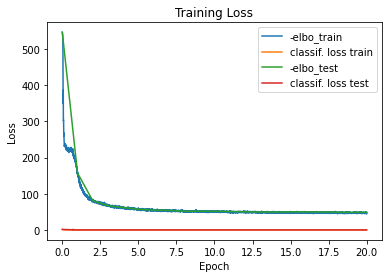

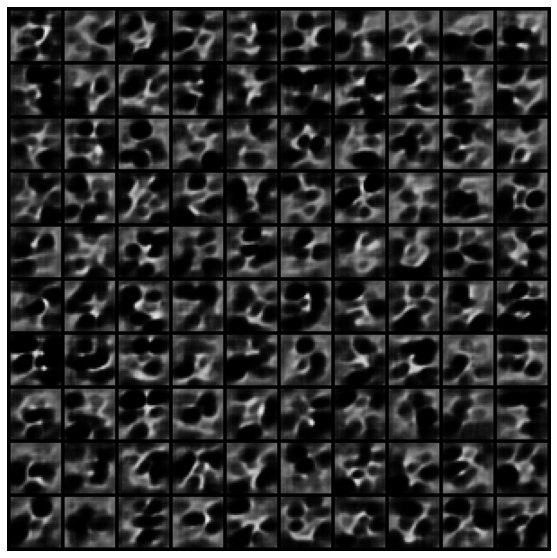

In [26]:
q2_results(q2)

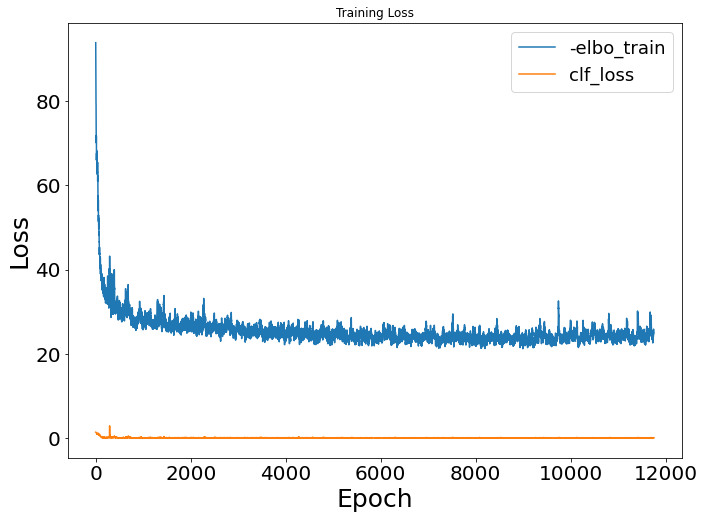

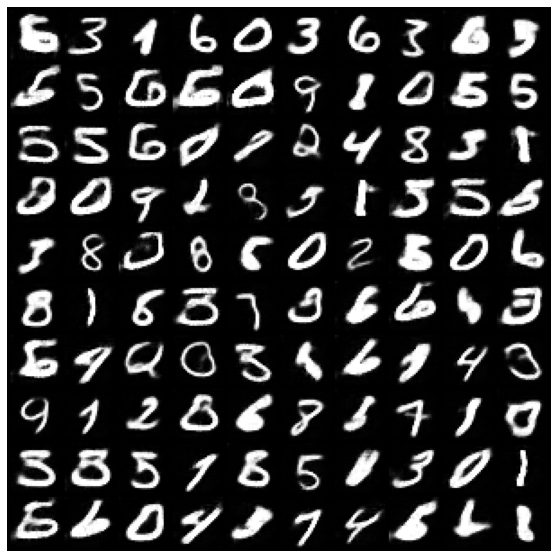

In [ ]:
q2_results(q2)